# Error metrics for the CR model

In [1]:
# Install dependencies
!pip install emcee corner --quiet

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.error_metrics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# ODE model for conversion reaction 
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)
   
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2

def batch_simulator_augment01(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and augmentation by zeros/ones
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, 0.0])  
        
    return sim_data

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## MCMC samples from the true posterior for the CR model

Problem: Given an observed data set, generate MCMC samples from the posterior distribution.

Reason: This is needed in order to define a performance metric.

Generate representative samples from each posterior via MCMC. This is time-intensive. If this has been run already once and results have been stored, once can directly proceed by loading them in the "Load" section.

In [5]:
n_params = 500   
true_params = prior(n_params) 
x_augment01 = batch_simulator_augment01(true_params, n_obs).astype(np.float32)

In [6]:
%%time
# "True" means via MCMC sampling
mcmc_means = np.empty((n_params, 2))

from multiprocessing import Pool

from tqdm import tqdm

def do_sth(i):
    present_timepoints = time_points[x_augment01[i,:,1]==1]
    present_data = x_augment01[i, x_augment01[i,:,1]==1, 0]
    
    def log_prior(x,y):   
        # Evaluates log-prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
        return norm.logpdf(x,-0.75,0.25) + norm.logpdf(y,-0.75,0.25)

    def log_likelihood(x,y):   
        # Calculates log-likelihood p(x_{1:N} | theta) by ignoring the missing data
        x = 10**x
        y = 10**y
        s = x + y
        b = x/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(present_timepoints)
        residual = (present_data - sol)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return - nllh

    def log_posterior(x,y):   
        # Evaluates the unnormalized log-posterior probability p(theta | x_{1:N}) according to Bayes' formula
        return log_likelihood(x,y) + log_prior(x,y)

    def log_posterior_v(x: np.ndarray):
        """Log-posterior with a single vector-valued argument."""
        x, y = x
        return log_posterior(x, y)

    def sample(n_sample=10000, n_walker=10):
        """Perform sampling using emcee."""
        n_dim = 2
        p0 = np.random.randn(n_walker, n_dim)
        #with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(n_walker, n_dim, log_posterior_v)
        sampler.run_mcmc(p0, n_sample)    
        samples = sampler.get_chain(flat=True)
        return samples

    # Sample
    samples = sample(n_sample=10000)
    
    # Posterior mean
    return (i, samples)

with Pool() as pool:
    results = list(tqdm(pool.imap_unordered(do_sth, range(n_params)), total=n_params))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:11<00:00,  6.11s/it]

CPU times: user 1.07 s, sys: 271 ms, total: 1.34 s
Wall time: 10min 11s


In [18]:
results = sorted(results, key=lambda x: x[0])
mcmc_samples = np.array([r for _, r in results])
print(mcmc_samples.shape)
mcmc_means = np.mean(mcmc_samples, axis=1)
print(mcmc_means.shape)
mcmc_stds = np.std(mcmc_samples, axis=1)

(100, 100000, 2)
(100, 2)


## Save results

In [20]:
np.save("true_params.npy", true_params)
np.save("mcmc_means.npy", mcmc_means)
np.save("mcmc_stds.npy", mcmc_stds)
np.save("x_augment01.npy", x_augment01)

## Load results

In [5]:
n_params = 500
true_params = np.load("true_params.npy")
mcmc_means = np.load("mcmc_means.npy")
mcmc_stds = np.load("mcmc_stds.npy")
x_augment01 = np.load("x_augment01.npy")

## Sample from BayesFlow using the different encodings

In [6]:
%%time

# Augment by 0/1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_samples=10000)
v_augment01 = bootstrap_metrics(np.swapaxes(param_samples_augment01, 0, 1), mcmc_means)
metrics_augment01 = display_metrics(v_augment01)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
NRMSE(k_1): 0.006 ± 0.000
NRMSE(k_2): 0.009 ± 0.001
R²(k_1): 0.999 ± 0.000
R²(k_2): 0.997 ± 0.000
Wall time: 3min 52s


In [8]:
%%time

# Insert -1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

x_insert = np.ones((n_params, n_obs, 1), dtype=np.float32)
for m in range(n_params):
    x_insert[m, :, 0] = x_augment01[m, :, 0]
    
# BayesFlow samples from the learned posterior    
param_samples_insert = amortizer.sample(x_insert, n_samples=10000)
v_insert = bootstrap_metrics(np.swapaxes(param_samples_insert, 0, 1), mcmc_means)
metrics_insert = display_metrics(v_insert)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
NRMSE(k_1): 0.006 ± 0.001
NRMSE(k_2): 0.011 ± 0.002
R²(k_1): 0.999 ± 0.000
R²(k_2): 0.995 ± 0.002
Wall time: 3min 26s


In [10]:
%%time

# Time labels
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_timelabels_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_time = np.empty((n_params, 10000, 2), dtype=np.float32)
for m in range(n_params):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_time = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_time[0, :, 0] = x_augment01[m, present_indices, 0]
    x_time[0, :, 1] = time_points[present_indices]
    param_samples_time[m] = amortizer.sample(x_time, n_samples=10000)
v_time = bootstrap_metrics(np.swapaxes(param_samples_time, 0, 1), mcmc_means)
metrics_time = display_metrics(v_time)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_timelabels_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
NRMSE(k_1): 0.004 ± 0.000
NRMSE(k_2): 0.008 ± 0.001
R²(k_1): 0.999 ± 0.000
R²(k_2): 0.998 ± 0.000
Wall time: 4min 5s


## Plotting methods

In [11]:
def true_vs_estimated(axarr, theta_true, theta_est, param_names):
    """ Plots a scatter plot with abline of the estimated posterior means vs true values. """
        
    # --- Plot true vs estimated posterior means on a single row --- #
    for j in range(len(param_names)):
        
        # Plot analytic vs estimated
        axarr[j].scatter(theta_est[:, j], theta_true[:, j], color='black', alpha=0.4)
        
        # get axis limits and set equal x and y limits
        lower_lim = min(axarr[j].get_xlim()[0], axarr[j].get_ylim()[0])
        upper_lim = max(axarr[j].get_xlim()[1], axarr[j].get_ylim()[1])
        axarr[j].set_xlim((lower_lim, upper_lim))
        axarr[j].set_ylim((lower_lim, upper_lim))
        axarr[j].plot(axarr[j].get_xlim(), axarr[j].get_xlim(), '--', color='black')
        
        # Compute NRMSE
        rmse = np.sqrt(np.mean( (theta_est[:, j] - theta_true[:, j])**2 ))
        nrmse = rmse / (theta_true[:, j].max() - theta_true[:, j].min())
        axarr[j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes,
                     size=11)
        
        # Compute R2
        r2 = r2_score(theta_true[:, j], theta_est[:, j])
        axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                     horizontalalignment='left',
                     verticalalignment='center',
                     transform=axarr[j].transAxes, 
                     size=11)
        
        axarr[j].set_ylabel('True')
        if j == len(param_names) - 1:
            # Label plot
            axarr[j].set_xlabel('Estimated')
        axarr[j].set_title(param_names[j], fontsize=11.5)
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)

In [12]:
def bar_chart(ax, values, column, category, se=None, y_lim=None):
    ax[column].set_title(category, pad=5)
    if se is not None:
        ax[column].bar(x=[1,2,3], height=values, yerr=se, capsize=10, width=1.0, 
                       color=[(0.46, 0.47, 0.93), (0.91, 0.44, 0.32), (0.16, 0.62, 0.56)])
    else: 
        ax[column].bar(x=[1], height=values[0], width=1.0, color=[(0.46, 0.47, 0.93)], label='Insert $-1$')
        ax[column].bar(x=[2], height=values[1], width=1.0, color=[(0.91, 0.44, 0.32)], label='Augment by $0/1$')        
        ax[column].bar(x=[3], height=values[2], width=1.0, color=[(0.16, 0.62, 0.56)], label='Time labels')
    ax[column].set_xticks([1,2,3])
    ax[column].set_xticklabels(['','',''])
    ax[column].tick_params(bottom=False)
    if y_lim is not None:
        ax[column].set_ylim(y_lim)

## Compare means and standard deviations

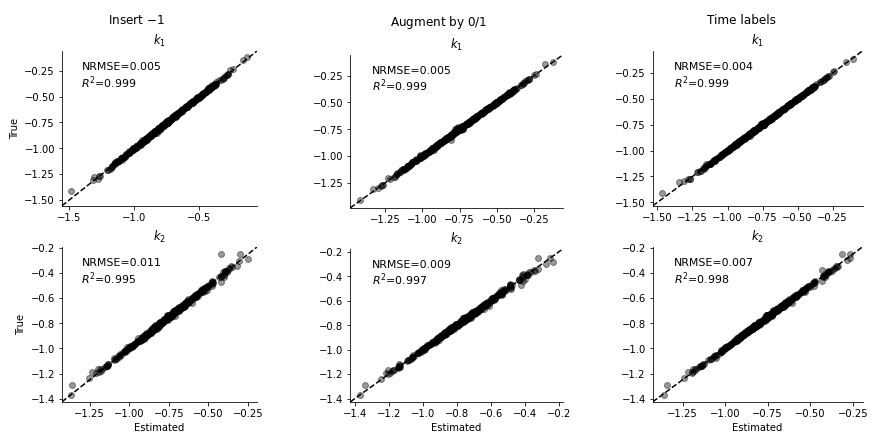

In [13]:
# Compare means of MCMC and BayesFlow samples
x = [1, 2, 3]
y = [4, 5, 6]

fig = plt.figure(figsize=(12, 6), constrained_layout=True)
subfigs = fig.subfigures(nrows=1, ncols=3, wspace=0.15)
all_axes = [subfig.subplots(nrows=2, ncols=1, gridspec_kw={'wspace': 0}) for subfig in subfigs.ravel()]

for ix, (samples, label) in enumerate([
    (param_samples_insert, "Insert $-1$"),
    (param_samples_augment01, "Augment by $0/1$"),
    (param_samples_time, "Time labels")
]):
    bayesflow_means = np.mean(samples, axis=1)
    axes = all_axes[ix].flat
    true_vs_estimated(axes, mcmc_means, bayesflow_means, ["$k_1$", "$k_2$"])
    subfigs[ix].suptitle(label)
    if ix > 0:
        for ax in axes:
            ax.set_ylabel(None)
plt.suptitle(" ", fontsize=0.1)

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/CR3_true_vs_estimated_mean.{fmt}", dpi=300, bbox_inches='tight')

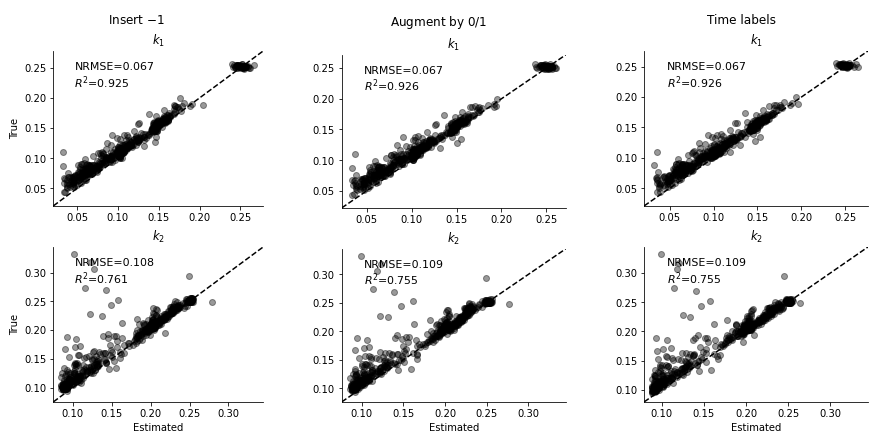

In [14]:
# Compare standard deviations of MCMC and BayesFlow samples
x = [1, 2, 3]
y = [4, 5, 6]

fig = plt.figure(figsize=(12, 6), constrained_layout=True)
subfigs = fig.subfigures(nrows=1, ncols=3, wspace=0.15)
all_axes = [subfig.subplots(nrows=2, ncols=1, gridspec_kw={'wspace': 0}) for subfig in subfigs.ravel()]

for ix, (samples, label) in enumerate([
    (param_samples_insert, "Insert $-1$"),
    (param_samples_augment01, "Augment by $0/1$"),
    (param_samples_time, "Time labels")
]):
    bayesflow_stds = np.std(samples, axis=1)
    axes = all_axes[ix].flat
    true_vs_estimated(axes, mcmc_stds, bayesflow_stds, ["$k_1$", "$k_2$"])
    subfigs[ix].suptitle(label)
    if ix > 0:
        for ax in axes:
            ax.set_ylabel(None)
plt.suptitle(" ", fontsize=0.1)

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/CR3_true_vs_estimated_std.{fmt}", dpi=300, bbox_inches='tight')

## Bar chart for error metrics

In [15]:
loss_insert = np.mean(np.array([-4.3960495, -4.248661, -4.1768427, -4.3904033, -4.435947, -4.434232, -4.4383836, -4.266319, -4.3987284, -4.535244, -4.2723074, -4.428317, -4.5995107, -4.5243692, -4.4310846, -4.334416, -4.424149, -4.369623, -4.3421245, -4.3548794, -4.173585, -4.476368, -4.5817485, -4.404334, -4.3472643, -4.4963193, -4.4705467, -4.4487114, -4.253648, -4.4434767, -4.4974604, -4.2953215, -4.451068, -4.24232, -4.164371, -4.341277, -4.272915, -4.2145443, -4.4357004, -4.3467817, -4.215269, -4.397397, -4.5873632, -4.145932, -4.5324078, -4.2637343, -4.5857573, -4.171008, -4.1500673, -4.237202, -4.2100234, -4.340564, -4.3622694, -4.1637554, -4.513895, -4.5100956, -4.368972, -4.428237, -4.3223934, -4.2325535, -4.1811543, -4.2405844, -4.398316, -4.47459, -4.3674974, -4.3121333, -4.362483, -4.340255, -4.0939813, -3.951858, -4.1614895, -4.3646164, -4.176381, -4.4661884, -4.4129705, -3.9955895, -4.276716, -4.3905106, -4.259055, -4.4058113, -4.3305354, -4.565419, -4.3090734, -4.3078194, -4.5178976, -4.4645605, -4.3760796, -4.518556, -4.4516544, -4.4953766, -4.1703043, -4.207532, -4.4243603, -4.3038645, -4.3120193, -4.1357546, -4.3413305, -4.2337, -4.2724047, -4.4629936, -4.197504, -4.378352, -4.223346, -4.5606875, -4.196471, -4.185503, -4.4750724, -4.3013005, -4.352478, -4.5964746, -4.3149376, -4.3866796, -4.2391715, -4.093623, -4.115385, -4.4082475, -4.383832, -4.43009, -4.387932, -4.30008, -4.3802614, -4.128556, -4.4221926, -4.3969145, -4.2861834, -4.290544, -4.338362, -4.307046, -4.1375375, -4.3882074, -4.2771297, -4.44913, -4.28508, -4.500954, -4.4719934, -4.520391, -4.6392856, -4.341422, -4.4590473, -4.5901747, -4.3234673, -4.1882815, -4.2705584, -4.3055925, -4.364131, -4.5368404, -4.2341256, -3.9530878, -4.4168305, -4.2928762, -4.250083, -4.1436696, -4.287792, -4.558877, -4.3770914, -4.4154787, -4.060956, -4.3674593, -4.2571626, -4.144888, -4.380452, -4.5653133, -4.308138, -3.8505797, -4.3947964, -4.322404, -4.13593, -4.338582, -4.3193073, -4.3704934, -4.249303, -4.3967047, -4.420765, -4.289043, -4.351571, -4.315685, -4.2478356, -4.382802, -4.3696375, -4.363194, -4.1491313, -4.346978, -4.4507585, -4.1926146, -4.442091, -4.576852, -4.0808535, -4.4018517, -4.450818, -4.2064247, -4.461434, -4.3198595, -4.369423, -4.3225784, -4.3065243, -4.310401, -4.3316073, -4.5813212, -4.397466, -4.4847403, -4.1506004, -4.0870476, -4.3757467, -4.3013735, -4.447141, -4.1552176, -4.1396966, -4.316448, -4.348506, -4.1185303, -4.4784737, -4.409424, -4.1209335, -4.129414, -4.095063, -4.508169, -4.4357624, -4.2601776, -4.375702, -4.493965, -4.3396583, -4.0765395, -4.33821, -4.304504, -4.568264, -4.404066, -4.4434757, -4.250114, -4.424864, -4.3194876, -4.0660677, -4.5090747, -4.183128, -4.3061266, -4.3287234, -4.5369244, -4.086916, -4.406846, -4.4313717, -4.338975, -4.326763, -4.278731, -4.218884, -4.4977856, -4.483575, -4.281203, -4.2256417, -4.252053, -4.610368, -4.438857, -4.491345, -4.226596, -4.3622537, -4.154854, -4.526837, -4.261828, -4.4769526, -4.641588, -4.35981, -4.594625, -4.312968, -4.5203896, -4.302356, -4.363592, -4.495185, -4.4129753, -4.378842, -4.4271965, -4.3829393, -4.3055973, -4.240765, -4.312744, -4.404497, -4.117785, -4.732834, -4.3919725, -4.2730303, -4.367404, -4.295253, -4.394249, -4.241049, -4.35223, -4.419976, -4.4919415, -4.2229733, -4.5289764, -4.2048483, -4.373878, -4.2741976, -4.3731847, -4.528984, -4.2252393, -4.250509, -4.334547, -4.197287, -4.3071194, -4.133362, -4.372077, -4.389126, -4.285825, -4.4365716, -4.1022606, -4.3917933, -4.273333, -4.36526, -4.2976475, -4.3201423, -4.36448, -4.3157606, -4.2858324, -4.425358, -4.225318, -4.3964972, -4.5024576, -4.354504, -4.263213, -4.3065057, -4.1671596, -4.3417664, -4.5095153, -4.4180975, -4.371545, -4.304406, -4.3311896, -4.575347, -4.3393927, -4.3675756, -4.447003, -4.4155445, -4.3936415, -4.2800064, -4.4938555, -4.4187074, -4.324347, -4.2501388, -4.273295, -4.191698, -4.462078, -4.226506, -4.2826147, -4.293773, -4.3260837, -4.2537117, -4.327066, -4.394346, -4.1966314, -4.217264, -4.393755, -4.4191723, -4.3905478, -4.1394863, -4.1478815, -4.408811, -4.2252803, -4.4501295, -4.3930445, -4.3152905, -4.3553, -4.551598, -4.309698, -4.2666907, -4.4188027, -4.600196, -4.1400585, -4.366226, -4.2388754, -4.2302437, -4.1848044, -4.3748617, -4.307178, -4.3153563, -4.688053, -4.3693137, -4.346966, -4.3170433, -4.45781, -4.318074, -4.514085, -4.2526474, -4.3358636, -4.06425, -4.1502075, -4.309682, -4.152642, -4.664139, -4.428123, -4.340992, -4.3695064, -4.1349525, -4.454917, -4.2343473, -4.216715, -4.3865843, -4.1940513, -4.337685, -4.3938117, -4.201975, -4.2802057, -4.245956, -4.3334017, -4.3952713, -4.431985, -4.44903, -4.190071, -4.335565, -4.3156505, -4.2241488, -4.249666, -4.357399, -4.3331046, -4.335571, -4.2975025, -4.4673796, -4.3154087, -4.245799, -4.381772, -4.162327, -4.238557, -4.506368, -4.182409, -4.3321524, -4.3663454, -4.304782, -4.329937, -4.16935, -4.352381, -4.3324976, -4.3311415, -4.3708177, -4.390207, -4.368433, -4.428252, -4.172553, -4.174061, -4.3731737, -4.3971176, -4.47016, -4.3267155, -4.5810075, -4.3843307, -4.070578, -4.301607, -4.4729533, -4.5044217, -4.445531, -4.1413054, -4.2889986, -4.260256, -4.528386, -4.3538036, -4.2955923, -4.5982704, -4.4483433, -4.4163947, -4.26815, -4.347974, -4.3394346, -4.3339386, -4.4304705, -4.16189, -4.325325, -4.310575, -4.540737, -4.2012873, -4.1895895, -4.130251, -4.369912, -4.2624364, -4.1770873, -4.286131, -4.433579, -4.074904, -4.2539954, -4.260856, -4.3673906, -4.409651, -4.200636, -4.4394493, -4.343136, -4.2597694, -4.201172, -4.277323, -4.3069706, -4.092922, -4.3366656, -4.2787194, -4.3429146, -4.470022, -4.0853786, -4.453726, -4.316635, -4.363097, -4.228425, -4.3551717, -4.171388, -4.422192, -4.332593, -4.4806757, -4.4246607, -4.4521465, -4.487507, -4.3712463, -4.250606, -4.4056196, -4.540901, -4.4613867, -4.3909655, -4.362006, -4.703623, -4.2436705, -4.3767257, -4.112878, -4.3063383, -4.4034653, -4.2686043, -4.5030637, -4.4990873, -4.4077806, -4.0505013, -4.3530397, -4.313859, -4.189202, -4.6282063, -4.373597, -4.4445944, -4.4545484, -4.161646, -4.3198905, -4.3622026, -4.3753767, -4.364935, -4.373516, -4.455722, -4.3898544, -4.524395, -4.4824934, -4.3240213, -4.5072308, -4.2943783, -4.14322, -4.373622, -4.3201895, -4.441331, -4.152838, -4.320573, -3.9065897, -4.314061, -4.324197, -4.147523, -4.5341554, -4.262883, -4.4697647, -4.3958344, -4.2998385, -4.43495, -4.200057, -4.5038724, -4.251773, -4.516423, -4.4291563, -4.4862623, -4.409789, -4.535776, -4.428763, -4.3592978, -4.6064234, -4.1917334, -4.3284974, -4.4869385, -4.2464075, -4.2386923, -4.498897, -4.2057886, -4.4428487, -4.1488028, -4.270852, -4.3273106, -4.366528, -4.3718176, -4.4725685, -4.388363, -4.482501, -4.4458466, -4.295556, -4.299534, -4.2900877, -4.41794, -4.5477066, -4.5031796, -4.513843, -3.9803162, -4.3376284, -4.4327, -4.2517114, -4.3043113, -4.4822035, -4.442189, -4.227865, -4.3951635, -4.3550835, -4.377402, -4.1825433, -4.4312735, -4.530921, -4.5542803, -4.292709, -4.2652655, -4.4075956, -4.424571, -4.383487, -4.4000688, -4.2362013, -4.226253, -4.506017, -4.484144, -4.173899, -4.2377033, -4.6207094, -4.356785, -4.3736477, -4.41191, -4.428659, -4.1934333, -4.151428, -4.4971285, -4.1939945, -4.1828065, -4.288883, -4.4434085, -4.4649982, -4.0100937, -4.454096, -4.39302, -4.4120426, -4.3703003, -4.6158915, -4.537224, -4.3263564, -4.4712257, -4.3948727, -4.342293, -4.5273066, -4.215142, -4.2468953, -4.269657, -4.2549434, -4.384403, -4.226399, -4.295774, -4.358714, -4.208424, -4.5107365, -4.2397766, -4.3968525, -4.3146896, -4.397452, -4.4392514, -4.6178265, -4.408677, -4.2466335, -4.3399496, -4.6756306, -4.258937, -4.4227304, -4.412243, -4.218669, -4.3106184, -4.2298584, -4.3981876, -4.3662376, -4.315543, -4.422844, -4.4857492, -4.401689, -4.5922875, -4.233119, -4.300889, -4.3105006, -4.4569817, -4.3865027, -4.563311, -4.4873834, -4.3494067, -4.419801, -4.247346, -4.431062, -4.360194, -4.4394875, -4.3366737, -4.294265, -4.474654, -4.4280453, -4.3578806, -4.4260464, -4.20825, -4.3092604, -4.4549465, -4.337507, -4.4968204, -4.3072295, -4.3183136, -4.4358587, -4.472534, -3.9489279, -4.421175, -4.3513756, -4.415316, -4.3037996, -4.3628225, -4.4550004, -4.298481, -4.5460587, -4.274036, -4.427933, -4.1928806, -4.5688314, -4.1697583, -4.4139175, -4.493599, -4.1377897, -4.362563, -4.48629, -4.3442383, -4.404394, -4.203842, -4.2201633, -4.30034, -4.2640815, -4.400161, -4.43386, -4.2386494, -4.1322823, -4.3221426, -4.232605, -4.092037, -4.4042788, -4.38247, -4.3571796, -4.4928937, -4.2964416, -4.3935423, -4.1427965, -4.4880047, -4.3503695, -4.2946186, -4.4759192, -4.6455545, -4.6149564, -4.3026266, -4.3958187, -4.4750752, -4.610756, -4.6486025, -4.0943403, -4.3246737, -4.2487545, -4.3006124, -4.396962, -4.3545227, -4.357921, -4.503996, -3.8986075, -4.224927, -4.3584566, -4.2327137, -4.529724, -3.9730313, -4.3687735, -4.2600923, -4.0745487, -4.326522, -4.4249296, -4.3838425, -4.2441235, -4.4031334, -4.3415875, -4.2731075, -4.22626, -4.2593307, -4.3095517, -4.2408857, -4.384413, -4.3894844, -4.255026, -4.3609905, -4.258428, -4.512507, -4.1045094, -4.4148264, -4.104473, -4.2647457, -4.470378, -4.3108115, -4.450425, -4.365171, -4.2810287, -4.5001388, -4.267557, -4.393565, -4.1695414, -4.565272, -4.503932, -4.454325, -4.377342, -4.5322857, -4.360806, -4.485118, -4.0686674, -4.422108, -4.0372868, -4.33022, -4.1970005, -4.3806744, -4.305894, -4.2947817, -4.285734, -4.2970276, -4.3987794, -4.47123, -4.1390886, -4.465076, -4.296837, -4.308323, -4.4282923, -4.2723994, -4.4445677, -4.4014378, -4.0120606, -4.2971478, -4.2412443, -4.417429, -4.257395, -4.257517, -4.283354, -4.3805933, -4.2921267, -4.3376317, -4.48324, -4.1864376, -4.468054, -4.682088, -4.3490295, -4.585256, -4.3018055, -4.404128, -4.440829, -4.35722, -4.456282, -4.4975786, -4.4028263, -4.568124, -4.44298, -4.6279793, -4.469311, -4.293065, -4.3289456, -4.313302, -4.172342, -4.246557, -4.2378325, -4.4098883, -4.499185, -4.2930784, -4.3417673, -4.3907886, -4.5399017, -4.5178986, -4.4949555, -4.4135466, -4.470579, -4.284153, -4.2412853, -4.6172624, -4.395531, -4.261861, -4.470318, -4.403161, -4.121196, -4.3973207, -4.2345576, -4.3346996, -4.351985, -4.4310484, -4.1696033, -4.3858433, -4.288442, -4.4587965, -4.344298, -4.5638905, -4.236041, -4.408025, -4.2314844, -4.455782, -4.2857747, -4.2446265, -4.395998, -4.619179, -4.374592, -4.4218454, -4.2904406, -4.2053394, -4.460663, -4.292704, -4.202235, -4.4597526, -4.395848, -4.341355, -4.298875, -4.490048, -4.4826965, -4.2327304, -4.546942, -4.174148, -4.4457364, -4.198879, -4.5570774, -4.4118323, -4.223278, -4.381725, -4.2751207, -4.4365177, -4.34785, -4.2823668, -4.51128, -4.3103895, -4.572454, -4.143592, -4.549778, -4.308245, -4.059342, -4.1175594, -4.2795687, -4.200551, -4.1951265, -4.2584157, -4.364576, -4.321418, -4.1974726, -4.2853913, -4.483009, -4.438536, -4.195735, -4.4918356, -4.3326855, -4.330469, -4.359874, -4.433157, -4.213879, -4.4156027, -4.348015, -4.425614, -4.4045405, -4.329892, -4.392375, -4.43517, -4.247867, -4.543539, -4.2715435, -4.2624254, -4.4171085, -4.453537, -4.2869186, -4.1460776, -4.549838, -4.1948457, -4.4040146, -4.2803383, -4.3003826, -4.496627, -4.379078, -4.2127895, -4.4824266, -4.3401465, -4.6271524, -4.5668163, -4.287958, -4.586351, -4.3613214, -4.4713097, -4.1583033, -4.5333886, -4.3483744, -4.1812563, -4.4894304, -4.481338, -4.3663607, -4.4113398, -4.414747, -4.2303414, -4.5303364, -4.491208, -4.12479, -4.457052, -4.335351, -4.333331, -4.211944, -4.1639924, -4.3948627, -4.6590524, -3.9759817]))

In [16]:
loss_augment01 = np.mean(np.array([-4.479716, -4.4155207, -4.526883, -4.3764105, -4.1897583, -4.3425455, -4.5749855, -4.2346773, -4.3793035, -4.3167176, -4.1357665, -4.421818, -4.064604, -4.5148325, -4.3417883, -4.3401613, -4.2867436, -4.501522, -4.261631, -4.20148, -4.538275, -4.141778, -4.007417, -4.4220424, -4.384932, -4.4078016, -4.3916616, -4.3843737, -4.335892, -4.316114, -4.305654, -4.2492495, -4.245966, -4.4470353, -4.226816, -4.357547, -4.3070846, -4.479064, -4.3700914, -4.475755, -4.241882, -4.2392807, -4.341581, -4.3175316, -4.5184402, -4.381639, -4.3162017, -4.3659286, -4.3548694, -4.4081507, -4.4960384, -4.239624, -4.2276216, -4.279927, -4.223095, -4.5661306, -4.3868876, -4.4817586, -4.218618, -4.556082, -4.577657, -4.425497, -4.313745, -4.349039, -4.270647, -4.3422933, -4.149185, -4.4048014, -4.392967, -4.123234, -4.487365, -4.1442585, -4.4096217, -4.3459473, -4.557041, -4.524347, -4.532776, -4.352956, -4.281504, -4.3052235, -4.305099, -4.342536, -4.450221, -4.2485247, -4.327407, -4.125869, -4.439053, -4.3303623, -4.2522254, -4.3999786, -4.35282, -4.518194, -4.187016, -4.264014, -4.3348694, -4.220692, -4.473986, -4.522498, -4.155671, -4.5085096, -4.565048, -4.2761426, -4.2767367, -4.3234224, -4.3988, -4.320429, -4.370259, -4.2952013, -4.1891074, -4.3196, -4.1585855, -4.415717, -4.4246697, -4.45796, -4.3404408, -4.294262, -4.55752, -4.39896, -4.43447, -4.5655937, -4.325719, -4.360587, -4.33407, -4.098218, -4.2906103, -4.137735, -4.461601, -4.522075, -4.1196165, -4.3127184, -4.254203, -4.227837, -4.2757726, -4.683948, -4.2031775, -4.6019387, -4.0507193, -4.240486, -4.3665705, -4.391753, -4.3094316, -4.4818363, -4.2482815, -4.287484, -4.519633, -4.306673, -4.357287, -4.3520694, -4.3230705, -4.375157, -4.1035314, -4.5065994, -4.5504847, -4.4128623, -4.4392376, -4.3199883, -4.2522635, -4.2873173, -4.354783, -4.262902, -4.2912292, -4.3423586, -4.428282, -4.3119845, -4.477132, -4.4965606, -4.3701744, -4.1294174, -4.380897, -4.2768292, -4.463643, -4.372188, -4.3835897, -4.228029, -4.2460675, -4.281185, -4.4358034, -4.5675573, -4.2270365, -4.1873083, -4.4491496, -4.3609314, -4.382014, -4.3478, -4.434348, -4.6407003, -4.5998483, -4.104583, -4.439643, -4.2872334, -4.361395, -4.4157476, -4.417719, -4.1459374, -4.419729, -4.558985, -4.44438, -4.254134, -4.337295, -4.313184, -4.5506344, -4.1101007, -4.5061817, -4.3363056, -4.287139, -4.3004746, -4.521427, -4.2058053, -4.2819495, -4.301521, -4.296277, -4.3562527, -4.3571396, -4.1949883, -4.323674, -4.1832457, -4.19563, -4.428695, -4.726572, -4.3582854, -4.2931056, -4.3186235, -4.2685795, -4.301442, -4.50014, -4.382981, -4.5401, -4.3678665, -4.0662885, -4.487466, -4.4472494, -4.2839355, -4.293195, -4.2951736, -4.22895, -4.2778597, -4.4093666, -4.2884903, -4.3953786, -4.335971, -4.464186, -4.3872266, -4.322689, -4.3438015, -4.672982, -4.2808666, -4.3754287, -4.4423485, -4.510022, -4.321853, -4.2744465, -4.428833, -4.415456, -4.4618483, -4.3942804, -4.466319, -4.475381, -4.52446, -4.1673937, -4.369587, -4.288279, -4.3449097, -4.2050877, -4.2246943, -4.3132033, -4.2434545, -4.4905086, -4.481892, -4.2725506, -4.287479, -4.3662753, -4.4526815, -4.605509, -4.3430996, -4.6269064, -4.4453063, -4.3066244, -4.576416, -4.2274776, -4.267931, -4.204548, -4.328435, -4.3952417, -4.482098, -4.250357, -4.353919, -4.3273926, -4.508355, -4.58363, -4.3823514, -4.298705, -4.138524, -4.3181314, -4.52106, -4.301187, -4.4688687, -4.399724, -4.5377817, -4.367376, -4.2253294, -4.3286095, -4.296392, -4.3007803, -4.393606, -4.2296653, -4.22318, -4.263422, -4.4233932, -4.3964634, -4.416212, -4.0618505, -4.4604845, -4.523612, -4.388028, -4.548833, -4.3341055, -4.12782, -4.338538, -4.550116, -4.47281, -4.3846197, -4.255021, -4.2977567, -4.4427156, -4.326144, -4.1572475, -4.2773714, -4.203553, -4.4195046, -4.156667, -4.3014593, -4.349497, -4.5805254, -4.2187557, -4.2685757, -4.3742185, -4.321856, -4.585105, -4.3376584, -4.2666116, -4.3393927, -4.6151495, -4.1237926, -4.3608093, -4.263854, -4.304133, -4.44178, -4.1807466, -4.1614084, -4.232436, -4.365077, -4.3503957, -4.4153166, -4.4180007, -4.192296, -4.5208387, -4.1602964, -4.386451, -4.2312393, -4.3659935, -4.4621058, -4.3569527, -4.4503164, -4.235426, -4.190731, -4.2168646, -4.29988, -4.451547, -4.4279013, -4.4120064, -4.22035, -4.226993, -4.394077, -4.4578032, -4.4253197, -4.3007, -4.48711, -4.5215445, -4.2687206, -4.193165, -4.5179377, -4.096615, -4.2170925, -4.4091563, -4.2794046, -4.206399, -4.3795033, -4.424002, -4.5446787, -4.247224, -4.5450125, -4.498011, -4.2981052, -4.319602, -4.4732914, -4.5355797, -4.3513155, -4.2723827, -4.5021443, -4.4206324, -4.5158095, -4.503773, -4.2862024, -4.4291368, -4.3217335, -4.210333, -4.420623, -4.343049, -4.5983295, -4.321485, -4.6268277, -4.2175674, -4.499189, -4.5230784, -4.2978516, -4.434269, -4.321796, -4.302878, -4.3730836, -4.2837024, -4.534355, -4.5534353, -4.3012147, -4.2515097, -4.258043, -4.534968, -4.207711, -4.3968678, -4.1694465, -4.0939636, -4.214221, -4.330058, -4.3198442, -4.0235734, -4.4604273, -4.407098, -4.3931184, -4.3250923, -4.3829603, -4.258767, -4.1069674, -4.3667545, -4.2810564, -4.150896, -4.15361, -4.467536, -4.0644608, -4.305803, -4.4136353, -4.341453, -4.5051622, -4.073791, -4.000585, -4.3178134, -4.408291, -4.318486, -4.468943, -4.23874, -4.529606, -4.3586893, -4.263032, -4.485161, -4.441682, -4.477765, -4.1274977, -4.187329, -4.248372, -4.4576945, -4.3673124, -4.146618, -4.5570006, -4.332912, -4.171892, -4.223383, -4.555977, -4.775321, -4.2380533, -4.5447783, -4.2689695, -4.414863, -4.5110326, -4.308798, -4.234598, -4.430574, -4.308993, -4.3178606, -4.488017, -4.2402163, -4.350048, -4.224577, -4.3853154, -4.2006526, -4.3770742, -4.317419, -4.2503576, -4.2557855, -4.2906404, -4.2623253, -4.300361, -4.316678, -4.1630316, -4.3000126, -4.276373, -4.3898225, -4.321105, -4.2037997, -4.3034687, -4.264562, -4.4005547, -4.286721, -4.3764424, -4.4220886, -4.527215, -4.356965, -4.276547, -4.480011, -4.2734146, -4.389536, -4.5937614, -4.3055754, -4.2378054, -4.2823935, -4.425731, -4.2083077, -4.10926, -4.389292, -4.2795367, -4.184232, -4.386484, -4.3778925, -4.19083, -4.6123304, -4.09492, -4.354735, -4.4273577, -4.246558, -4.403654, -4.238441, -4.442862, -4.533662, -4.449448, -4.3863134, -4.4223175, -4.600679, -4.410121, -4.3537564, -4.490699, -4.321574, -4.396357, -4.4402943, -4.2289042, -4.1578875, -4.210891, -4.409133, -4.4560976, -4.3923674, -4.180664, -4.3403673, -4.4486704, -4.3256454, -4.399945, -4.2886934, -4.2685432, -4.164831, -4.3474126, -4.4479446, -4.276767, -4.2280583, -4.2052383, -4.0338526, -4.3624315, -4.1525087, -4.2949853, -4.3928404, -4.3634267, -4.415593, -4.3648934, -4.3728657, -4.346125, -4.4588523, -4.3798475, -4.4677687, -4.4441795, -4.2939835, -4.2427444, -4.4292717, -4.5797095, -4.2791095, -4.109922, -4.147174, -4.4620137, -4.2577667, -4.1122365, -4.1764994, -4.321769, -4.648031, -4.2956314, -4.22977, -4.446171, -4.3972797, -4.194906, -4.3260517, -4.2548532, -4.3910203, -4.311753, -4.433985, -4.321457, -4.420848, -4.251042, -4.4477153, -4.281975, -4.4202075, -4.4215374, -4.477119, -4.253128, -4.3004932, -4.4281025, -4.441214, -4.138956, -4.433672, -4.5454226, -4.3752794, -4.3806076, -4.4369106, -4.4822884, -4.331894, -4.1281013, -4.403977, -4.292697, -4.0528584, -4.37925, -4.4906216, -4.6172743, -4.310384, -4.506834, -4.416, -4.2279425, -4.4243565, -4.4244604, -4.3828063, -4.1886477, -4.3882155, -4.4536676, -4.3703537, -4.424385, -4.373261, -4.2773857, -4.1634746, -4.3362107, -4.5096855, -4.5181074, -4.339692, -4.4636602, -4.1819706, -4.307432, -4.303293, -4.0074677, -4.3071737, -4.189626, -4.1918087, -4.434023, -4.2126846, -4.569721, -4.215019, -4.479247, -4.073578, -4.371484, -4.202593, -4.4274087, -4.495463, -4.664504, -4.354031, -4.338842, -4.5580406, -4.3393083, -4.5136814, -4.4346533, -4.2593393, -4.4861727, -4.2793193, -4.513035, -4.3958197, -4.187412, -4.3531084, -4.053459, -4.2890997, -4.4277706, -4.458519, -4.3979836, -4.498211, -4.482744, -4.3646774, -4.4699, -4.3259735, -4.2749443, -4.4216747, -4.493662, -4.205372, -4.3614645, -4.248573, -4.3980565, -4.3716407, -4.442953, -4.368322, -4.2877393, -4.3198547, -4.520274, -4.161632, -4.1863213, -4.3714013, -4.5755467, -4.331197, -4.4020762, -4.2536416, -4.5432262, -4.6590643, -4.415476, -4.300622, -4.453239, -4.370741, -4.46847, -4.2958565, -4.314561, -4.383115, -4.188412, -4.4211774, -4.247288, -4.383807, -4.473148, -4.342191, -4.6851735, -4.429076, -4.234951, -4.302399, -4.195751, -4.3721056, -4.1549125, -4.481979, -4.167446, -4.3838253, -4.341322, -4.218454, -4.462377, -4.240067, -4.4200115, -4.1417923, -4.286217, -4.4192367, -4.209481, -4.3725452, -4.243952, -4.3209414, -4.306949, -4.5328174, -4.206866, -4.490091, -4.122261, -4.547006, -4.2366905, -4.439002, -4.5416317, -4.3352947, -4.3886323, -4.1910954, -4.2720556, -4.4796095, -4.1394157, -4.33187, -4.3012214, -4.313, -4.4972887, -4.3174787, -4.286342, -4.2270913, -4.293845, -4.332736, -4.490444, -4.2930236, -4.4620447, -4.233197, -4.187854, -4.27054, -4.35413, -4.539333, -4.350314, -4.423727, -4.1827607, -4.2161045, -4.1228495, -4.4201984, -4.703828, -4.229231, -4.393049, -4.2292485, -4.165714, -4.5517406, -4.3508635, -4.375363, -4.386224, -4.5477505, -4.6650934, -4.4149046, -4.3958917, -4.2184258, -4.4525175, -4.1185465, -4.1797576, -4.437813, -4.471179, -4.1341987, -4.2647233, -4.290723, -4.2977057, -4.3457775, -4.264557, -4.2223716, -4.3414683, -4.4706707, -4.4517784, -4.3568683, -4.1833706, -4.482549, -4.1645823, -4.365601, -4.48174, -4.509053, -4.47611, -4.31513, -4.2300644, -4.431697, -4.515562, -4.4223757, -4.2049522, -4.4285355, -4.426795, -4.346324, -4.222565, -4.207398, -4.436748, -4.4718556, -4.351258, -4.2600017, -4.3795466, -4.297518, -4.2055206, -4.2537365, -4.428529, -4.2349663, -4.319764, -4.4741535, -4.3804417, -4.450942, -4.2827463, -4.225803, -4.316892, -4.439906, -4.184999, -4.3171372, -4.471365, -4.570735, -4.3268213, -4.5281286, -4.3872757, -4.3985934, -4.0152206, -4.47777, -4.276148, -4.325777, -4.4208803, -4.3291454, -4.339491, -4.271943, -4.3316927, -4.2186093, -4.393793, -4.513895, -4.4459796, -4.420512, -4.163475, -4.312111, -4.473335, -4.362274, -4.4861155, -4.464732, -4.393108, -4.4642034, -4.2711625, -4.541172, -4.274196, -4.2307024, -4.3912277, -4.155826, -4.184443, -4.445949, -4.488554, -4.6546726, -4.3777227, -4.2854195, -4.1828504, -4.4250927, -4.687878, -4.494302, -4.2710023, -4.520072, -4.230764, -4.450607, -4.2106795, -4.5002356, -4.6079803, -4.587502, -4.2474604, -4.2950726, -4.067348, -4.302666, -4.263265, -4.3893642, -4.487571, -4.2612667, -4.4084854, -4.2427325, -4.5014033, -4.3795424, -4.33628, -4.1939716, -4.372924, -4.167693, -4.368715, -4.2582045, -4.5449743, -4.4751725, -4.4485426, -4.4879313, -4.5783796, -4.2189417, -4.4684424, -4.5430946, -4.337472, -4.416406, -4.41494, -4.4092093, -4.419641, -4.3900013, -4.2963047, -4.324587, -4.357422, -4.2232447, -4.2284045, -4.3774757, -4.4010835, -4.4391937, -4.435973, -4.492244, -4.408434, -4.426754, -4.433331, -4.454794, -4.3174577, -4.303537, -4.44532, -4.382183, -4.4825907, -4.400137, -4.609915, -4.3919754, -4.2705674, -4.5240736, -4.3121796, -4.325863, -4.4030237, -4.214073, -4.415315, -4.299867, -4.281176, -4.298416, -4.464381, -4.362488, -4.443221, -4.582122, -4.328052, -4.3658996, -4.4476943, -4.390527, -4.2810526, -4.223926, -4.511285, -4.53482, -4.373776, -4.277738, -4.232436, -4.5179296, -4.2254972, -4.413837, -4.6348085, -4.5798097, -4.521432, -4.4807386, -4.328779, -4.4698935, -4.19823, -4.2608705]))

In [17]:
loss_time = np.mean(np.array([-4.5709047, -5.210583, -4.539612, -4.4511824, -4.5553093, -3.5117083, -3.5081768, -3.4560308, -5.159121, -4.593253, -4.394737, -3.4369452, -4.543606, -5.148114, -4.375474, -5.298231, -5.0764937, -3.3280067, -4.454635, -4.371948, -5.193782, -5.296562, -5.179199, -5.173602, -5.130726, -4.5716376, -4.4928565, -5.1157074, -3.456181, -5.0702677, -4.6061664, -4.6107807, -5.2237396, -5.095409, -5.370742, -3.5061922, -4.327216, -3.5012817, -3.280445, -4.5000887, -5.3076506, -3.3800797, -4.4605684, -3.21704, -5.1655583, -4.5173297, -4.5122843, -4.601448, -4.400543, -4.6856766, -3.2404509, -3.346465, -5.143009, -3.3530083, -4.5039997, -3.3248892, -5.1045218, -5.220194, -5.1761937, -3.3284197, -4.4028015, -3.4412746, -4.520067, -3.458517, -3.513786, -4.3206487, -5.157756, -5.240712, -4.438079, -3.585442, -4.4661083, -5.191261, -4.499401, -4.50748, -4.54494, -4.548834, -3.229567, -4.480954, -4.5645385, -5.3121758, -3.3119195, -4.692387, -4.4477406, -5.201906, -3.0429926, -4.4401846, -5.1526217, -3.414352, -3.138032, -4.5540934, -4.604869, -4.412138, -3.4122903, -5.120681, -3.4031906, -4.6015205, -4.618412, -4.395175, -4.433858, -4.5882607, -4.5133495, -4.357443, -5.15102, -4.5874968, -3.392227, -4.5672207, -3.564348, -4.489717, -4.443838, -4.495054, -3.4679441, -4.4489822, -3.6055908, -5.3201065, -4.6797595, -3.3622468, -3.3849761, -4.541013, -5.307392, -4.4671474, -4.4620266, -3.135291, -5.238159, -5.224185, -3.1099567, -3.1621654, -4.3717995, -5.307269, -3.1173387, -3.631896, -5.0862246, -5.117675, -4.4809265, -4.508913, -4.429241, -3.3207674, -3.2947607, -4.4756413, -3.3801281, -3.5669475, -5.178953, -5.1461124, -4.493518, -4.5626326, -5.074275, -5.293631, -3.2350187, -5.1442976, -4.5460715, -4.586419, -4.6188283, -4.3932657, -3.5649638, -4.6171093, -3.4928832, -4.5342817, -5.037091, -4.4702387, -5.0437427, -4.747261, -5.122061, -5.108631, -4.5029097, -4.5625215, -4.321203, -3.2914267, -4.6611786, -3.2947016, -4.6199718, -5.236918, -3.3537211, -5.2633057, -3.1829321, -3.3950887, -5.1698103, -5.2031355, -3.3249905, -4.467606, -4.4513164, -5.094255, -4.982327, -5.203685, -4.458931, -5.174827, -4.582261, -5.162758, -3.369721, -4.551509, -4.6617002, -5.128603, -3.2540584, -3.6540723, -3.2908, -4.4295373, -3.4854832, -3.335162, -5.1773987, -3.2685406, -3.1335578, -4.9995956, -5.1795225, -4.657236, -3.3688436, -5.028676, -4.535261, -3.4280343, -3.3848193, -3.5121176, -4.659954, -3.3814511, -4.5088544, -4.5458136, -5.140689, -5.2405734, -3.3778281, -4.4930086, -5.2387013, -3.2250247, -4.496367, -4.547064, -4.6213074, -4.48604, -3.3581467, -4.633347, -5.2148733, -4.597453, -3.3125048, -4.688064, -3.7395382, -3.112177, -3.2145762, -4.479559, -3.243876, -5.1231737, -5.0909357, -5.1940575, -5.1975665, -5.1145096, -3.2306519, -4.5667877, -4.4975758, -5.096219, -4.627202, -4.502048, -3.0946114, -4.605842, -4.448481, -3.403647, -4.538601, -4.46431, -3.497496, -3.1923962, -5.112669, -3.303193, -3.3503585, -3.3197503, -4.5389957, -5.211525, -3.3306603, -3.1132681, -3.0894933, -4.403287, -3.3517303, -4.5323277, -4.4680037, -4.5143614, -4.442682, -4.385187, -5.098595, -3.242793, -4.584819, -5.210223, -4.438672, -3.2250166, -4.4442186, -3.320234, -4.570448, -5.223221, -5.21299, -4.893777, -3.144086, -4.594558, -5.1286488, -4.594334, -3.1804206, -3.4360733, -5.2357163, -3.3623302, -3.394528, -4.376007, -3.519581, -4.6701164, -4.55532, -3.3908439, -5.244191, -3.2600617, -4.522501, -3.3927805, -4.4595747, -3.5433714, -4.701818, -5.235573, -5.2214603, -4.721406, -4.441736, -3.3451915, -3.168655, -4.4567747, -4.5046253, -3.4751663, -5.089755, -4.933859, -5.2293177, -5.3717833, -5.238778, -5.178015, -4.5386524, -4.964376, -4.502022, -4.594563, -3.4599137, -5.2819076, -3.464185, -3.2460766, -4.4790106, -5.185174, -5.082098, -3.4720876, -3.3076649, -3.2823756, -4.8629436, -4.593542, -4.4881144, -3.4545193, -5.4375954, -3.1857898, -4.388091, -5.242079, -3.3628097, -5.3571587, -4.519775, -5.0572953, -5.179861, -5.1258097, -4.526663, -3.4952526, -5.096778, -3.4756656, -5.2334967, -4.498171, -3.3829427, -5.228997, -4.5506024, -3.5511358, -3.5054703, -4.416391, -3.389893, -4.962573, -4.6197324, -5.0996366, -5.1636367, -5.1508074, -4.460985, -5.081313, -5.277819, -3.4880123, -3.3479595, -4.4803762, -5.195652, -3.3502636, -5.1244297, -5.1286507, -5.2092886, -5.2357755, -5.1909003, -3.5664368, -3.4314828, -3.3721137, -4.4340277, -3.31778, -3.1005955, -4.5106106, -3.2461777, -3.536117, -4.608406, -4.521016, -3.5382078, -3.3291576, -3.5203557, -3.5209541, -3.394292, -3.3605695, -3.4663346, -5.1367893, -5.2591143, -3.50324, -5.3283634, -4.469322, -5.1656733, -4.501877, -4.3791, -5.0890865, -3.321526, -4.5033197, -4.9986067, -4.615676, -3.5786333, -4.4868975, -3.560431, -3.4888737, -4.3017273, -4.5149, -5.2519784, -4.444026, -5.0605745, -4.4879513, -5.152546, -5.106939, -4.4802313, -4.3436785, -5.220071, -4.531972, -4.5334206, -3.4437313, -3.2958446, -3.1139674, -3.3816254, -4.617554, -4.539816, -5.1939964, -5.1209965, -4.3831735, -5.16002, -3.6536393, -4.6139717, -5.0622654, -5.1304073, -4.495545, -3.4620194, -3.2127993, -5.1908474, -5.244249, -5.217306, -5.159112, -4.4063673, -5.092226, -5.1177344, -3.3794618, -4.384621, -4.598281, -4.527616, -5.2897086, -4.630744, -5.2962, -3.2378612, -4.6221285, -5.171629, -5.217009, -3.3555195, -4.2905474, -3.2726483, -5.2543116, -4.4618177, -3.3660944, -3.5321078, -3.377038, -4.3935213, -4.436575, -5.080054, -4.5497646, -3.2193527, -5.199588, -4.522293, -3.3865466, -4.5885153, -4.6728134, -5.26007, -5.243107, -5.123522, -4.362523, -4.442998, -3.0237908, -5.1828723, -3.263545, -5.1479883, -4.4819736, -5.1455393, -3.3782117, -5.128832, -3.2738266, -3.286068, -3.4897022, -5.2898064, -4.608939, -4.6129055, -5.361317, -3.256281, -4.6000233, -3.3269901, -3.3750126, -3.3287745, -3.0225496, -4.549881, -5.181595, -5.112009, -4.58515, -4.5333586, -4.3863316, -5.2635813, -3.6426835, -4.628359, -3.2721539, -3.2555892, -4.492463, -3.3260975, -3.5821176, -5.1601353, -3.5204623, -5.0509686, -4.3833714, -5.1525564, -5.0537443, -4.540742, -4.4465427, -5.139679, -3.5258312, -4.503331, -4.5701003, -4.536261, -4.4182115, -5.0483804, -3.247767, -4.9985485, -3.397133, -3.41265, -3.3968298, -5.158017, -4.4471965, -4.503369, -4.4107847, -4.6129804, -5.182814, -3.2377186, -4.5425787, -4.5340524, -5.154884, -3.3819659, -3.3084722, -3.5223813, -4.498727, -5.247023, -5.2278423, -4.976349, -4.4814825, -4.863638, -3.3507457, -4.510066, -5.077125, -3.5329032, -5.16992, -4.524581, -4.581869, -5.1900673, -3.3232634, -4.556285, -3.40212, -4.498213, -3.4539537, -5.105088, -5.0328493, -5.203186, -4.6659045, -3.2475922, -5.2437453, -3.499642, -5.3610973, -5.266397, -3.3482485, -4.978791, -5.2209244, -3.1127558, -4.5779953, -3.4652941, -3.6863055, -5.152777, -3.347894, -5.139738, -3.0954165, -5.1745577, -5.1176987, -4.6295238, -5.1586285, -4.40919, -3.5157785, -4.4119425, -4.552532, -5.052953, -4.5850763, -5.1044073, -4.6133623, -4.5283623, -3.0075378, -3.2316482, -5.2898374, -4.628585, -4.809907, -4.3771095, -4.441012, -3.2774875, -4.4856553, -4.5489235, -3.3663554, -3.312625, -5.0729666, -5.0915837, -3.2250834, -4.1888924, -3.3231735, -4.473517, -4.978342, -5.1181345, -5.336197, -4.4031754, -3.473466, -4.680369, -4.56057, -4.4314775, -5.248077, -5.0493984, -5.0720177, -3.3473096, -4.4676623, -4.535479, -4.3374, -5.1324883, -5.3547535, -5.082619, -4.455085, -5.0787373, -4.5145, -4.5102954, -4.47145, -3.3171248, -5.3690796, -3.3607256, -4.3292704, -4.498077, -3.1932907, -4.948606, -4.399166, -4.4813004, -3.5025833, -4.578518, -5.4192076, -4.3955603, -4.5378675, -3.5379186, -4.549908, -3.24264, -5.1840916, -4.4451623, -3.1912837, -3.573843, -4.4060698, -5.1003575, -3.3509417, -4.54927, -4.620138, -4.7442617, -3.5268185, -3.415383, -4.5384135, -3.4296355, -3.254743, -5.197879, -5.090682, -3.286379, -3.1273532, -5.1636105, -3.3362184, -3.4631424, -5.0910945, -5.175213, -3.5402355, -4.4422045, -5.1260257, -5.382875, -3.5686677, -5.1467867, -5.2708373, -4.4291444, -3.4787307, -5.0382366, -3.5019867, -5.369483, -3.4524276, -4.597527, -4.712241, -5.184122, -5.163709, -4.5654593, -3.5202258, -5.1042137, -5.2266173, -4.3464622, -4.5710917, -3.5887022, -4.556135, -5.252078, -5.1681705, -4.396268, -4.3970094, -5.2557693, -4.5886054, -3.187078, -4.555686, -4.4637985, -3.2757845, -4.4493675, -4.6562586, -5.1033573, -4.453376, -3.362285, -3.2386878, -5.115641, -4.46019, -3.3025253, -3.38754, -4.4797916, -3.5487046, -4.5775805, -3.385162, -5.3069243, -3.2328339, -3.414981, -4.5428944, -3.6935112, -4.5559487, -3.5252528, -3.2955403, -5.1157694, -5.2605114, -3.3702621, -5.163661, -3.2704449, -3.296123, -4.532317, -5.1673126, -3.4226234, -3.3792233, -4.550069, -3.2994452, -4.5524054, -5.257254, -3.2983065, -4.632094, -4.6258097, -4.371952, -4.4502335, -4.631441, -3.194705, -3.3628542, -5.2694983, -4.5051794, -4.5102615, -3.4301014, -3.5975757, -3.1351209, -5.1897326, -4.484941, -5.150938, -5.176608, -3.4173079, -4.266739, -4.6014433, -4.550435, -5.1583796, -5.253331, -5.13481, -4.491997, -4.711463, -3.4001002, -5.1130333, -4.525276, -4.49171, -3.3223453, -5.2777443, -3.3624806, -5.078283, -4.6468916, -3.4128866, -3.251602, -4.649293, -3.3956199, -5.074369, -5.274659, -3.3116164, -4.4335594, -5.0631156, -5.3341274, -3.5208194, -3.303218, -4.3256836, -4.6219144, -3.2351537, -4.477459, -4.469669, -4.5537667, -3.2016525, -4.518336, -5.0373707, -4.560649, -3.3876648, -3.487441, -4.4399695, -3.2131662, -3.282543, -3.2504025, -5.167562, -4.6608315, -4.444996, -4.5869355, -5.262393, -3.4325542, -5.014405, -3.4970233, -5.311105, -4.495617, -5.150613, -5.2638817, -5.220008, -3.365316, -4.521799, -3.4445615, -5.0355587, -5.2663, -4.4114394, -4.5751414, -3.4770374, -5.105545, -3.246693, -5.2695656, -4.3722367, -5.3056183, -5.238191, -5.1564097, -4.35712, -3.2745223, -3.6377473, -4.5704737, -5.3168454, -4.66818, -3.5962582, -4.356071, -3.3285537, -4.4829307, -5.171558, -4.949238, -5.029581, -4.4368315, -5.2769628, -3.3762379, -5.371532, -5.234867, -3.467533, -5.0698643, -4.5227675, -3.193169, -5.1068583, -4.5491123, -3.394787, -5.2538624, -3.4020839, -5.140271, -3.4218254, -5.1755104, -5.233329, -3.2282002, -4.5351386, -3.4535623, -3.2429333, -3.2691941, -4.5982714, -4.551523, -3.4009123, -4.4651346, -3.3719358, -5.1207805, -3.3640914, -4.6356964, -3.3398733, -4.660192, -5.258381, -3.5267897, -4.35572, -4.484119, -3.3654408, -3.4253821, -4.413781, -3.2216833, -4.639946, -3.0474305, -5.317119, -4.477214, -3.4218311, -3.255725, -5.2659593, -3.2597342, -5.0392427, -3.4662998, -4.4285154, -5.137082, -4.5082207, -5.1770515, -4.539892, -5.1536183, -3.1816275, -3.4580066, -3.2772086, -3.447566, -4.4675007, -4.4807525, -5.137805, -4.460915, -4.633629, -5.217516, -5.1813164, -3.5523076, -5.1814775, -3.3060434, -4.713028, -5.079041, -4.230942, -4.549429, -3.509363, -3.214399, -4.558093, -4.6170516, -5.1653414, -4.4032087, -3.291811, -3.5904462, -3.4440024, -5.282755, -5.270746, -4.524529, -4.353842, -3.4387503, -5.3048677, -3.373043, -5.1543193, -4.4714108, -3.5613751, -4.4082613, -5.1333, -4.587753, -3.2159631, -4.655611, -5.143334, -5.263337, -3.4532754, -4.489271, -3.463487, -3.4141598, -4.6215353, -5.2601767, -5.1776347, -3.4080682, -3.43297, -3.4495835, -5.2594004, -4.4749136, -5.17163, -4.4696136, -4.6711845, -4.5207787, -4.463871, -3.341181, -5.2546806, -5.1287775, -4.5039635, -4.586705, -5.036545, -4.520683, -3.5198069, -4.423954, -4.4812484, -4.516098, -3.141028, -5.2304106, -4.559531, -4.6176195, -5.2783003, -4.6814446, -4.622712, -4.4214544, -3.688174, -5.1375475, -3.4415526, -3.4633126]))

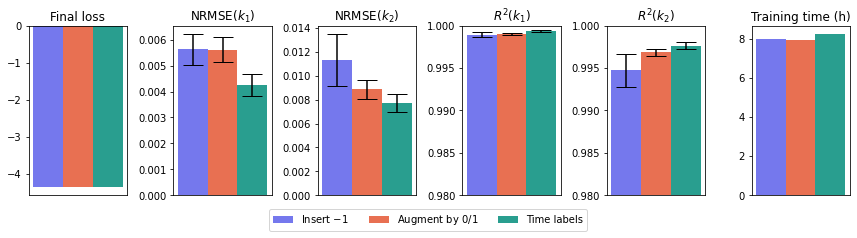

In [18]:
fig, ax = plt.subplots(1, 6, figsize=(12, 3))

bar_chart(
    ax, np.array([loss_insert, loss_augment01, loss_time]), 0, 'Final loss',
)
bar_chart(
    ax, np.array([metrics_insert[0,0], metrics_augment01[0,0], metrics_time[0,0]]), 1, 'NRMSE$(k_1)$', 
    se=np.array([metrics_insert[1,0], metrics_augment01[1,0], metrics_time[1,0]]),
)
bar_chart(
    ax, np.array([metrics_insert[0,1], metrics_augment01[0,1], metrics_time[0,1]]), 2, 'NRMSE$(k_2)$', 
    se=np.array([metrics_insert[1,1], metrics_augment01[1,1], metrics_time[1,1]]),
)
bar_chart(
    ax, np.array([metrics_insert[0,2], metrics_augment01[0,2], metrics_time[0,2]]), 3, '$R^2(k_1)$', 
    se=np.array([metrics_insert[1,2], metrics_augment01[1,2], metrics_time[1,2]]), 
    y_lim=np.array([0.98, 1])
)
bar_chart(
    ax, np.array([metrics_insert[0,3], metrics_augment01[0,3], metrics_time[0,3]]), 4, '$R^2(k_2)$', 
    se=np.array([metrics_insert[1,3], metrics_augment01[1,3], metrics_time[1,3]]), 
    y_lim=np.array([0.98, 1]), 
)
bar_chart(
    ax, np.array([8+0/60, 7+57/60, 8+15/60]), 5, 'Training time (h)', 
)

for axes in ax: 
    handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.11), ncol=4)
plt.tight_layout()
plt.show()
for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/CR3_metrics.{fmt}", dpi=300, bbox_inches='tight')